# Set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm

import matplotlib.pyplot as plt

import arviz as az
import seaborn as sns

import os
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels

from scipy.stats import gaussian_kde
from pyro.ops.stats import (
    gelman_rubin,
    split_gelman_rubin,
    autocorrelation,
    effective_sample_size,
    resample,
    quantile,
    weighed_quantile
)

import pickle

In [2]:
import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

In [3]:
Device = 'cpu'

# Data

In [4]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
# X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values
X_test = pd.read_csv('LocalDisease/X_1_1.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values


train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)


# Emulator Result

In [ ]:
loaded_samples_chain1 = torch.load("mcmc_samples_2.pt", map_location=Device)

In [ ]:
loaded_samples_chain2 = torch.load("mcmc_samples_1.pt", map_location=Device)

# MCMC V 2 chains

In [ ]:
autocorrelation(loaded_samples_chain1['param_0'], dim=0)

In [ ]:
statsmodels.tsa.stattools.acf(loaded_samples_chain1['param_0'], nlags=1199)

In [ ]:
true_params_tensor = test_x[0]

param_names = sorted(list(loaded_samples_chain1.keys()))

true_params = {name: true_params_tensor[i].item() for i, name in enumerate(param_names)}


mcmc_samples = {}
for param in loaded_samples_chain1.keys():
    mcmc_samples[param] = torch.stack([loaded_samples_chain1[param], loaded_samples_chain2[param]])

n_chains = 2
diagnostics_results = {}

for param, samples_chains in mcmc_samples.items():
    true_value = true_params[param]
    n_samples = samples_chains.shape[1]
    
    # rhat ...
    rhat = gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    split_rhat = split_gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    ess = effective_sample_size(samples_chains, chain_dim=0, sample_dim=1)
    
    diagnostics_results[param] = {
         "R-hat": rhat.item(),
         "Split R-hat": split_rhat.item(),
         "Effective Sample Size": ess.item()
    }
    print(f"{param}: R-hat = {rhat.item():.3f}, split R-hat = {split_rhat.item():.3f}, ESS = {ess.item():.1f}")
    
    # Trace Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(n_chains):
         plt.plot(samples_chains[i].numpy(), marker='o', label=f"Chain {i+1}")
    plt.axhline(true_value, color='green', linestyle='--', linewidth=2, label="True value")
    plt.title(f"Trace Plot for {param}")
    plt.xlabel("Sample Index")
    plt.ylabel(param)
    plt.legend()
    
    # Quantiles
    plt.subplot(1, 2, 2)
    all_samples = samples_chains.flatten()
    plt.hist(all_samples.numpy(), bins=15, density=True, alpha=0.7, color='gray')
    plt.axvline(true_value, color='green', linestyle='-', linewidth=2, label="True value")
    qs = quantile(all_samples, probs=[0.025, 0.5, 0.975], dim=0)
    for q in qs:
         plt.axvline(q.item(), color='red', linestyle='--', linewidth=2)
    plt.title(f"Histogram with Quantiles for {param}")
    plt.xlabel("Parameter Value")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

    # ACF
    plot_acf(samples_chains[0].numpy(), lags=50)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title(f"ACF Plot for {param} (Chain 1)")
    plt.show()

    
#     acf = autocorrelation(mcmc_samples[param], dim=0)
#     plt.figure(figsize=(6, 4))
#     plt.plot(acf.numpy(), marker='o')
#     plt.title(f"Autocorrelation for {param} (Chain 1)")
#     plt.xlabel("Lag")
#     plt.ylabel("Autocorrelation")
#     plt.show()
    
    # Weighed Quantile
    # 使用均匀权重（对数权重为0）时，带权重分位数应与普通分位数一致
#     log_weights = torch.zeros_like(samples)
#     wq = weighed_quantile(samples, probs=[0.025, 0.5, 0.975], log_weights=log_weights, dim=0)
#     print(f"{param} weighed quantiles: {wq}\n")


# MCMC V 1 chain

In [ ]:
with open("Result/L.MGP_21_mcmc_result/result_35.pkl", "rb") as f:
    loaded_samples_chain1 = pickle.load(f)

In [18]:
with open("PlotData/MVGP_21_mcmc_result/result_1.pkl", "rb") as f:
    loaded_samples_chain1 = pickle.load(f)

In [16]:
with open("PlotData/L.DKMGP_21_mcmc_result/result_1.pkl", "rb") as f:
    loaded_samples_chain1 = pickle.load(f)

In [ ]:
with open("PlotData/DNN_21_mcmc_result/result_1.pkl", "rb") as f:
    loaded_samples_chain1 = pickle.load(f)

In [5]:
with open("LocalDisease/Result/MVGP_21_mcmc_result/result_1.pkl", "rb") as f:
    loaded_samples_chain1 = pickle.load(f)

In [7]:
loaded_samples_chain1

{'param_0': tensor([4.9722, 4.9722, 4.9722,  ..., 4.9722, 4.9722, 4.9722]),
 'param_1': tensor([0.6832, 0.6832, 0.6832,  ..., 0.6832, 0.6832, 0.6832]),
 'param_2': tensor([4.9218, 4.9218, 4.9218,  ..., 4.9218, 4.9218, 4.9218]),
 'param_3': tensor([0.6107, 0.6107, 0.6107,  ..., 0.6107, 0.6107, 0.6107]),
 'param_4': tensor([4.9383, 4.9383, 4.9383,  ..., 4.9383, 4.9383, 4.9383]),
 'param_5': tensor([4.7618, 4.7618, 4.7618,  ..., 4.7618, 4.7618, 4.7618]),
 'param_6': tensor([4.9941, 4.9941, 4.9941,  ..., 4.9941, 4.9941, 4.9941]),
 'param_7': tensor([4.9470, 4.9470, 4.9470,  ..., 4.9470, 4.9470, 4.9470]),
 'param_8': tensor([4.9444, 4.9444, 4.9444,  ..., 4.9444, 4.9444, 4.9444]),
 'param_9': tensor([2.7773, 2.7773, 2.7773,  ..., 2.7768, 2.7768, 2.7768])}

In [ ]:
loaded_samples_chain1 = torch.load("mcmc_samples_6.pt", map_location=Device)

param_0: R-hat = nan, split R-hat = nan, ESS = nan


LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

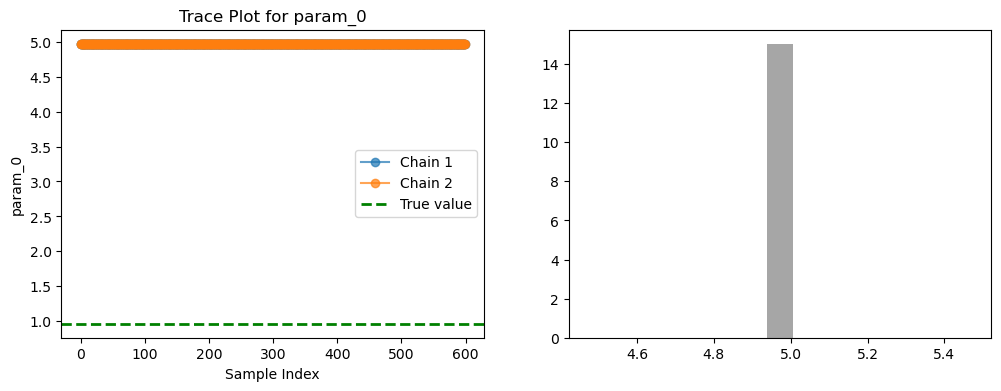

In [6]:
single_chain_samples = loaded_samples_chain1  # dict: param -> Tensor[n_samples]

# 将每条参数的样本拆成两半
def split_chain(chain_tensor):
    n = chain_tensor.shape[0]
    half = n // 2
    return chain_tensor[:half], chain_tensor[half:2*half]

# 整理成 mcmc_samples：param -> Tensor[2, n_half]
mcmc_samples = {}
for param, samples in single_chain_samples.items():
    chain_a, chain_b = split_chain(samples)
    # 如果原链长度是奇数，可以选择丢弃最后一个样本或做其他处理
    mcmc_samples[param] = torch.stack([chain_a, chain_b], dim=0)

# 真实值
param_names = sorted(list(single_chain_samples.keys()))
### 记得改
true_params_tensor = test_x[0]

true_params = {name: true_params_tensor[i].item() for i, name in enumerate(param_names)}


# 诊断和可视化
for param, samples_chains in mcmc_samples.items():
    true_value = true_params[param]
    
    # 计算诊断量
    rhat = gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    split_rhat = split_gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    ess = effective_sample_size(samples_chains, chain_dim=0, sample_dim=1)
    print(f"{param}: R-hat = {rhat:.3f}, split R-hat = {split_rhat:.3f}, ESS = {ess:.1f}")
    
    # 绘制 Trace Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(2):
        plt.plot(samples_chains[i].cpu().numpy(), marker='o', label=f"Chain {i+1}", alpha=0.7)
    plt.axhline(true_value, color='green', linestyle='--', linewidth=2, label="True value")
    plt.title(f"Trace Plot for {param}")
    plt.xlabel("Sample Index")
    plt.ylabel(param)
    plt.legend()
    
    # 绘制 Histogram + Quantiles
    plt.subplot(1, 2, 2)
    all_samps = samples_chains.reshape(-1).cpu().numpy()

    xmin, xmax = np.percentile(all_samps, [0.5, 99.5])

    plt.hist(all_samps, bins=15, density=True, alpha=0.7, color='gray')

    kde = gaussian_kde(all_samps)
    x_grid = np.linspace(xmin, xmax, 200)
    # plt.plot(x_grid, kde(x_grid), color='blue', linewidth=2, label="KDE")
    plt.plot(x_grid, kde(x_grid), color='blue', linewidth=2)

    plt.axvline(true_value, color='green', linestyle='-', linewidth=2, label="True value")
    qs = torch.quantile(torch.from_numpy(all_samps), torch.tensor([0.025, 0.5, 0.975]))
    for q in qs:
        plt.axvline(q.item(), color='red', linestyle='--', linewidth=2)
    
    # plt.xlim(0.1, 5)

    plt.title(f"Histogram + 2.5/50/97.5% Quantiles")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()
    
    # 绘制 ACF（仅第一“伪链”）
    plt.figure(figsize=(6,4))
    plot_acf(samples_chains[0].cpu().numpy(), lags=40)
    plt.title(f"ACF for {param} (Chain 1)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()

In [ ]:
single_chain_samples = loaded_samples_chain1  # dict: param -> Tensor[n_samples]

# 将每条参数的样本拆成两半
def split_chain(chain_tensor):
    n = chain_tensor.shape[0]
    half = n // 2
    return chain_tensor[:half], chain_tensor[half:2*half]

# 整理成 mcmc_samples：param -> Tensor[2, n_half]
mcmc_samples = {}
for param, samples in single_chain_samples.items():
    chain_a, chain_b = split_chain(samples)
    # 如果原链长度是奇数，可以选择丢弃最后一个样本或做其他处理
    mcmc_samples[param] = torch.stack([chain_a, chain_b], dim=0)

# 真实值
# param_names = sorted(list(single_chain_samples.keys()))
# true_params_tensor = test_x[34]
# true_params = {name: true_params_tensor[i].item() for i, name in enumerate(param_names)}

# 诊断和可视化
for param, samples_chains in mcmc_samples.items():
    # true_value = true_params[param]
    
    # 计算诊断量
    rhat = gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    split_rhat = split_gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    ess = effective_sample_size(samples_chains, chain_dim=0, sample_dim=1)
    print(f"{param}: R-hat = {rhat:.3f}, split R-hat = {split_rhat:.3f}, ESS = {ess:.1f}")
    
    # 绘制 Trace Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(2):
        plt.plot(samples_chains[i].cpu().numpy(), marker='o', label=f"Chain {i+1}", alpha=0.7)
    # plt.axhline(true_value, color='green', linestyle='--', linewidth=2, label="True value")
    plt.title(f"Trace Plot for {param}")
    plt.xlabel("Sample Index")
    plt.ylabel(param)
    plt.legend()
    
    # 绘制 Histogram + Quantiles
    plt.subplot(1, 2, 2)
    all_samps = samples_chains.reshape(-1).cpu().numpy()
    plt.hist(all_samps, bins=15, density=True, alpha=0.7, color='gray')
    # plt.axvline(true_value, color='green', linestyle='-', linewidth=2, label="True value")
    qs = torch.quantile(torch.from_numpy(all_samps), torch.tensor([0.025, 0.5, 0.975]))
    for q in qs:
        plt.axvline(q.item(), color='red', linestyle='--', linewidth=2)
    plt.title(f"Histogram + 2.5/50/97.5% Quantiles")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()
    
    # 绘制 ACF（仅第一“伪链”）
    plt.figure(figsize=(6,4))
    plot_acf(samples_chains[0].cpu().numpy(), lags=40)
    plt.title(f"ACF for {param} (Chain 1)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()

# Likelihood

## L.MGP

In [ ]:
row_idx = 0

input_point = test_y_21[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k=500)

MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_MultitaskGP(
    local_train_x, local_train_y, n_tasks = local_train_y.shape[1], 
    covar_type = 'RBF', lr=0.05, num_iterations=5000, patience=50, device=Device)

## L.DKMGP

In [ ]:
row_idx = 0

input_point = test_y_21[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k=500)

MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_NNMultitaskGP(
        local_train_x, local_train_y, n_tasks = local_train_y.shape[1], 
        feature_extractor_class = FeatureE.FeatureExtractor_4, covar_type = 'RQ', 
        lr=0.05, num_iterations=5000, patience=50, device = Device)

## MVGP

In [ ]:
checkpoint = torch.load('multitask_gp_checkpoint_21.pth', map_location=Device)
model_params = checkpoint['model_params']

MVGP_models = GP_models.MultitaskVariationalGP(train_x, train_y_21, 
                                               num_latents=model_params['num_latents'], 
                                               num_inducing=model_params['num_inducing'], 
                                               covar_type=model_params['covar_type']).to(Device)

MVGP_models.load_state_dict(checkpoint['model_state_dict'])

MVGP_likelihoods = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y_21.shape[1]).to(Device)
MVGP_likelihoods.load_state_dict(checkpoint['likelihood_state_dict'])

MVGP_models.eval()
MVGP_likelihoods.eval()

In [ ]:
param_names = sorted(
    [n for n in loaded_samples_chain1 if n.startswith('param_')],
    key=lambda s: int(s.split('_')[1])
)


theta_samples = torch.stack([loaded_samples_chain1[n] for n in param_names], dim=-1)
num_samples = theta_samples.shape[0]

In [ ]:
model, likelihood = MVGP_models, MVGP_likelihoods

model.eval()
likelihood.eval()

row_idx = 0

log_likes = []

with torch.no_grad():
    for i in range(num_samples):
        theta = theta_samples[i]
        theta = torch.tensor(theta, dtype=torch.float32).unsqueeze(0)
        # f_pred = model(theta)  

        # y_pred_dist = likelihood(f_pred)
        y_pred_dist = Prediction.preds_distribution_fast_pred_var(model, likelihood, theta)

        y_obs = test_y_21[row_idx]            
        ll = torch.exp(y_pred_dist.log_prob(y_obs))
        log_likes.append(ll.item())


log_likes = np.array(log_likes)

plt.figure(figsize=(8,4))
plt.plot(log_likes, lw=1)
plt.xlabel('Sample index')
plt.ylabel('Predictive Likelihood')
plt.title('Trace of Predictive Likelihood')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
theta = test_x[0].unsqueeze(0)

In [ ]:
y_pred_dist = Prediction.preds_distribution_fast_pred_var(model, likelihood, theta)

y_obs = test_y_21[row_idx]            
torch.exp(y_pred_dist.log_prob(y_obs))

In [ ]:
y_pred_dist.mean

In [ ]:
y_obs

# End